# Image Reconstruction with the ASTRA Toolbox

This notebook shows how the raw data from a scan abtained from the rotating scanner can be used to reconstruct an image. We define the distance from the center of the scanner to the source (LED) and detector (PT), the number of views and detectors, the raw data, the desired size of our reconstructed image and the reconstruction algorithm to use (SIRT by default here).

The initiation and trnsformation code is my own work, but the ASTRA usage follows established patterns as used in the ASTRA documentation and examples, and some code was included from the ASTRA manual.

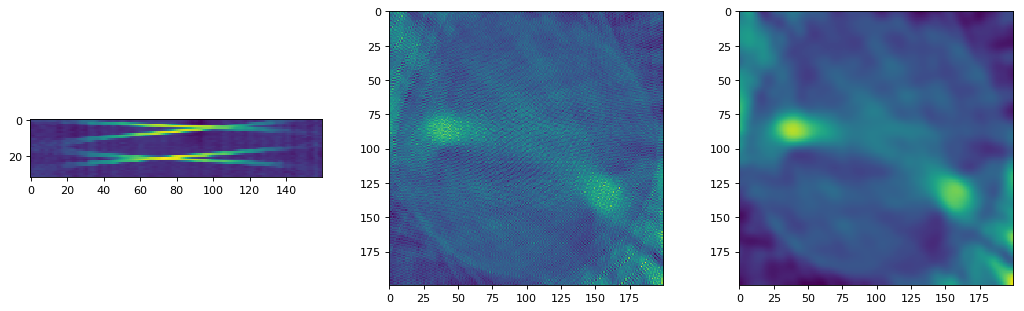

In [1]:
# Import required libraries
import skimage.filters
from matplotlib import pyplot as plt
import math, random
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import astra

%matplotlib inline

# First, set constants and load data

# Constants
dist_d = 55/50 #(70mm)
dist_e = 105/50 #(95mm)
nviews = 32
ndetectors = 160
nvdetectors = 160 # Can optionally simulate having fewer detectors by changing this number
algorithm='SIRT'

# Data
bb = pd.read_csv('12Aug_BASE_two_pens.csv')
br = pd.read_csv('12Aug_R_two_pens.csv')
readings = np.asarray(br)
base = np.asarray(bb).T
for r in range(len(readings)):
    readings[r] = readings[r]-base

# Defining distances in pixels
IMSIZE = 200
R = dist_d*IMSIZE/2
D = dist_e*IMSIZE/2

# Transforming from a round fan-beam to a fan-flat projection (See report)
beta = np.linspace(0, math.pi, 160)
alpha = np.asarray([R*math.sin(b-math.pi/2)/(R**2 + D**2)**0.5 for b in beta])
tau = np.asarray([(R+D)*math.tan(a) for a in alpha])

readings2 = []
tau_new = np.linspace(-(max(tau)/2), 1.3*max(tau)/2, nvdetectors) # Can change bounds. GOod to stick within max

for r in readings:
    f = interp1d(tau, r, kind='cubic') # Can change to linear
    readings2.append(f(tau_new))


# Reconstructing

# Defining the geometry in ASTRA
vol_geom = astra.create_vol_geom(IMSIZE, IMSIZE)
angles = np.linspace(0,2*math.pi,nviews);
d_size = (tau[-1]-tau[0])/nvdetectors
proj_geom= astra.create_proj_geom('fanflat', d_size, nvdetectors, angles, D, R);
proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
sinogram_id = astra.data2d.create('-sino', proj_geom, np.asarray(readings2))

# Plotting sinogram - new (transformed) set of readings
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(readings2) #<< Set title

# Doing the reconstruction, in this case with the SIRT algorithm (can change to 'FBP')
rec_id = astra.data2d.create('-vol', vol_geom)

cfg = astra.astra_dict(algorithm)
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run the algorithm
astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(rec)
norm_rec = rec/np.amax(rec)
blurred = skimage.filters.gaussian(norm_rec, 3)
ax3 = plt.subplot(2, 3, 3)
ax3.imshow(blurred)

plt.savefig('reconstruction.png')


# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)